<a href="https://colab.research.google.com/github/Rhinoffensive/emo-cv/blob/master/CNN_lab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Imports

In [0]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

tf.reset_default_graph()

## Load Data

You can normalize input data "x" if needed. You can use "np.squeeze" to remove single-dimensional entries from the shape of an array. You probably need to convert labels "y" to one-hot vector for loss function.

In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

x_train = x_train / 255.0
x_test = x_test / 255.0

y_train = np.squeeze(y_train) #[1,X] --> [x]; 1 boyutları ortadan kaldırıyor.
y_test = np.squeeze(y_test)

y_train_OH = np.zeros([50000,10])
y_train_OH[np.arange(50000),y_train] = 1

y_test_OH = np.zeros([10000,10])
y_test_OH[np.arange(10000),y_test] = 1

## Define placeholders

Define input and output placeholders. It is a good idea to pass dropout rate also as a placeholder.

In [181]:
len(y_train)

50000

In [0]:
X = tf.placeholder(tf.float32,[None,32,32,3])
Y = tf.placeholder(tf.float32,[None,10])
P = tf.placeholder(tf.float32)
Y_C = tf.placeholder(tf.int64, [None])

## Define network

Define the network as a function.Recommended functions are:

### Look at [tf.layers](https://www.tensorflow.org/api_docs/python/tf/layers) to find necessary functions

In [0]:
def convolution_model(x, keep_prob):
  
    net = tf.layers.conv2d(inputs=x,
                             filters=32,
                             kernel_size = [5,5],
                             padding='same',
                             activation=tf.nn.relu)
    net = tf.layers.batch_normalization(net)
    net = tf.nn.dropout(net,keep_prob)
    
    net = tf.layers.max_pooling2d(inputs=net,
                                   pool_size=[3,3],
                                   strides=2,
                                  padding='same')
    
    net = tf.layers.conv2d(inputs=net,
                             filters=16,
                             kernel_size =[5,5],
                             padding='same',
                             activation=tf.nn.relu)
    
    net = tf.layers.batch_normalization(net)
    net = tf.nn.dropout(net,keep_prob)
    
    net = tf.layers.max_pooling2d(inputs=net,
                                   pool_size=[3,3],
                                   strides=2,
                                  padding='same')
    
    net = tf.layers.conv2d(inputs=net,
                             filters=32,
                             kernel_size =[5,5],
                             padding='same',
                             activation=tf.nn.relu)
    
    net = tf.layers.batch_normalization(net)
    net = tf.nn.dropout(net,keep_prob)
    
    net = tf.layers.max_pooling2d(inputs=net,
                                   pool_size=[3,3],
                                   strides=2,
                                  padding='same')
    
    net = tf.reshape(net,[-1,512])
    
    net = tf.layers.dense(inputs=net,
                             units=128,
                             activation=tf.nn.relu)
    net = tf.layers.batch_normalization(net)
    net = tf.nn.dropout(net,keep_prob)
    
    logits = tf.layers.dense(inputs=net,
                             units =10,
                             activation=None)
     
    predictions = tf.nn.softmax(logits)
    

  
  
    return logits,predictions

## Define cost function

Define cost with respect to predictions and labels.

In [184]:
model_logits,model_predictions = convolution_model(X,P)
y_pred_cls = tf.argmax(model_predictions, axis=1)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels = Y, logits=model_logits)
cost = tf.reduce_mean(cross_entropy)

W0626 09:03:12.876632 140582378719104 deprecation.py:323] From <ipython-input-183-9e9661208a4d>:8: batch_normalization (from tensorflow.python.layers.normalization) is deprecated and will be removed in a future version.
Instructions for updating:
Use keras.layers.BatchNormalization instead.  In particular, `tf.control_dependencies(tf.GraphKeys.UPDATE_OPS)` should not be used (consult the `tf.keras.layers.batch_normalization` documentation).
W0626 09:03:12.957604 140582378719104 deprecation.py:506] From <ipython-input-183-9e9661208a4d>:9: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## Define optimizer

Adam is recommended

In [0]:
optimizer = tf.train.AdamOptimizer().minimize(cost)

## Define performance measures

In [0]:
correct_prediction = tf.equal(y_pred_cls, Y_C)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## Create TensorFlow session


In [0]:
session = tf.Session()

## Initialize variables

The variables for `weights`,`filters` and `biases` must be initialized before we start optimizing them.

In [0]:
session.run(tf.global_variables_initializer())

## Define train function

Don't forget to use batches since dataset is large.

Hint : One of the simplest way to define batch is

`for b in range(dataset_size//batch_size):      
    x_batch = x_train[b * batch_size : (b+1) * batch_size]`

In [0]:
def train():
    
    acc_list = []
    
    for b in range(50000//batch_size):
            
        x_batch = x_train[b*batch_size:(b+1)*batch_size]
        y_true_batch = y_train_OH[b*batch_size:(b+1)*batch_size]
        y_c_batch = y_train[b*batch_size:(b+1)*batch_size]
        
        _,acc = session.run([optimizer,accuracy], feed_dict={X: x_batch, Y: y_true_batch, Y_C: y_c_batch, P:0.7})
        
        acc_list.append(acc)
    
    return np.average(acc_list)

## Define test function

In [0]:
def test():
    
    # Run the model to get predictions for test data
    cls_pred = session.run(y_pred_cls, {X: x_test, Y: y_test_OH, Y_C: y_test, P:1})
    
    # Get true labels
    cls_true = y_test
    
    # Calculate the difference betweeb predictions and true labels
    correct_prediction = np.equal(cls_pred, cls_true)
    
    # Calculate the total accuracy
    acc = np.mean(correct_prediction)

    # Print the accuracy.
    return acc

## Performance before training

The accuracy is expected to be around 10%

In [191]:
test()

0.1004

## Performance after training

Measure training and test accuracy for at least 10 epochs, show it on a epoch/accuracy graph. The network is expected to reach around 70% accuracy at 10 epochs. 

epoch 0 train 0.24509998 test 0.3678


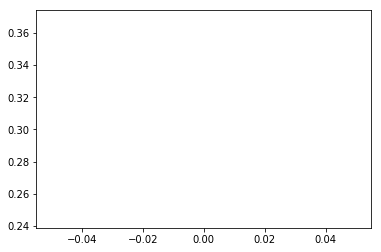

epoch 1 train 0.38527995 test 0.411


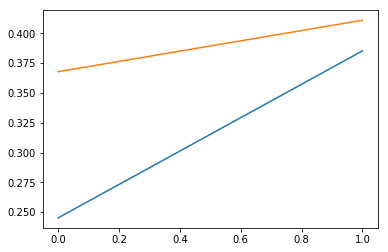

epoch 2 train 0.4474 test 0.4568


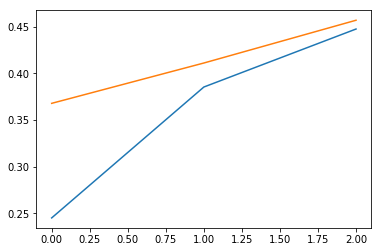

epoch 3 train 0.48516002 test 0.4953


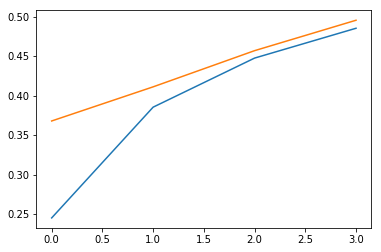

epoch 4 train 0.51408 test 0.508


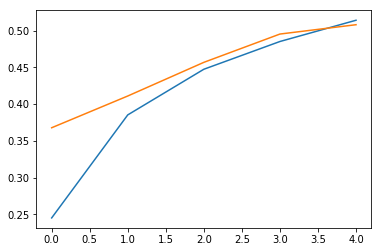

epoch 5 train 0.53353995 test 0.5171


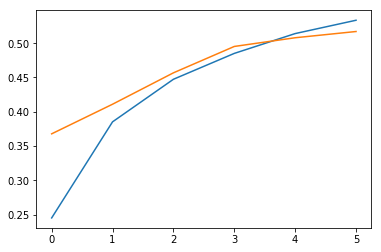

epoch 6 train 0.55065995 test 0.5174


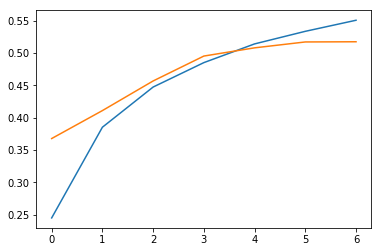

epoch 7 train 0.56093997 test 0.5328


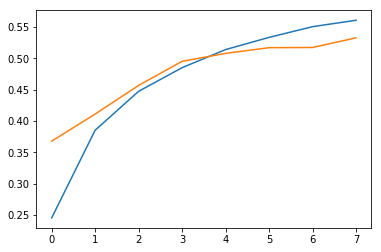

epoch 8 train 0.57872003 test 0.5624


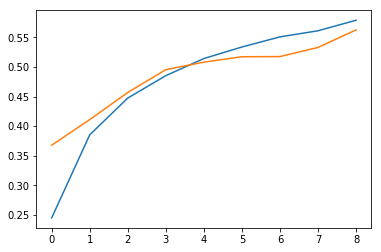

epoch 9 train 0.59314 test 0.5538


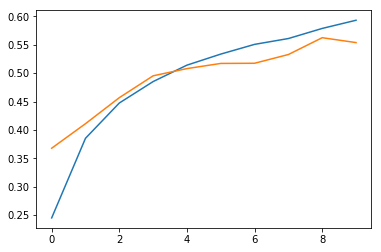

epoch 10 train 0.60324 test 0.5627


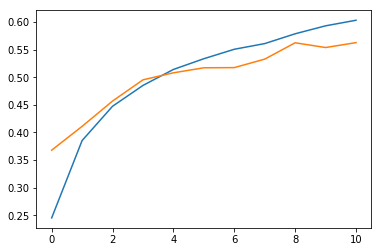

epoch 11 train 0.61128 test 0.5668


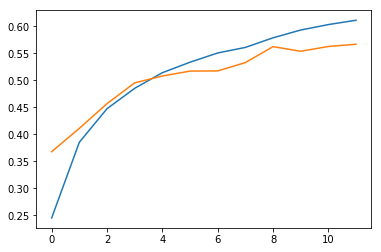

epoch 12 train 0.62294 test 0.5897


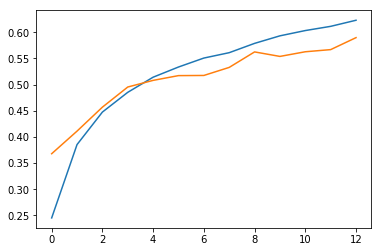

epoch 13 train 0.63115996 test 0.5899


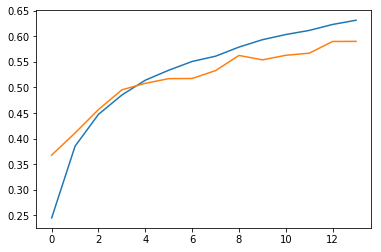

epoch 14 train 0.64038 test 0.5891


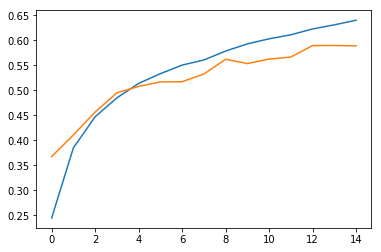

epoch 15 train 0.64435995 test 0.5995


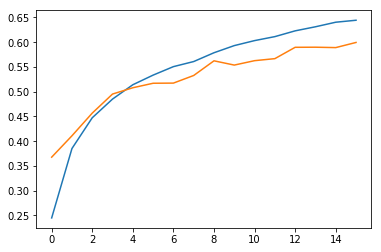

epoch 16 train 0.64854 test 0.5963


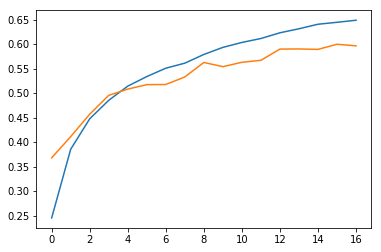

epoch 17 train 0.65608 test 0.602


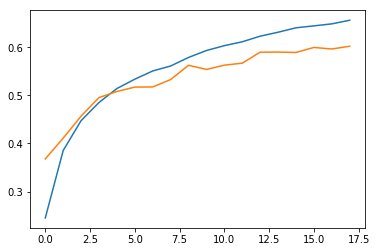

epoch 18 train 0.65713996 test 0.604


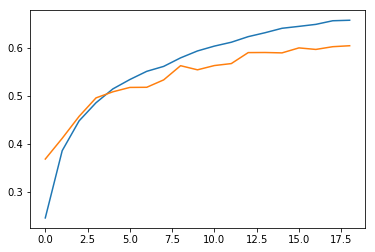

epoch 19 train 0.6638 test 0.6132


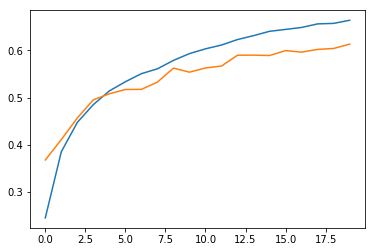

epoch 20 train 0.67183995 test 0.607


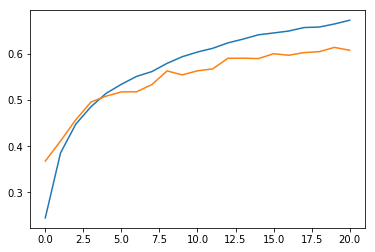

epoch 21 train 0.67850006 test 0.614


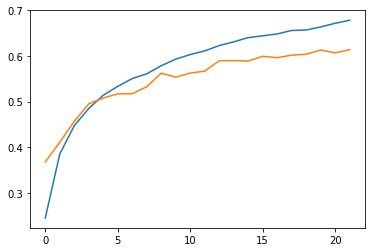

epoch 22 train 0.68027997 test 0.6263


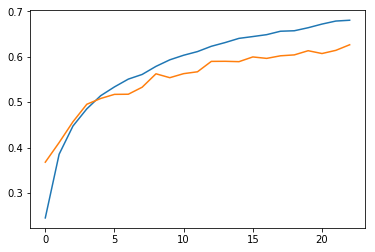

epoch 23 train 0.68272 test 0.62


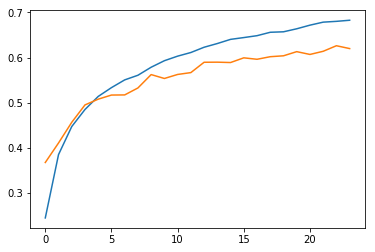

epoch 24 train 0.69138 test 0.6159


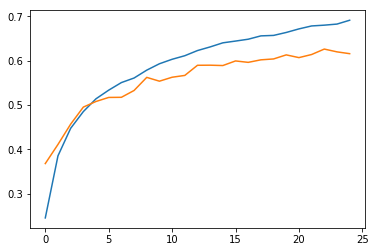

epoch 25 train 0.68806 test 0.6427


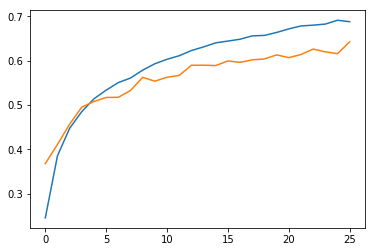

epoch 26 train 0.69338006 test 0.6153


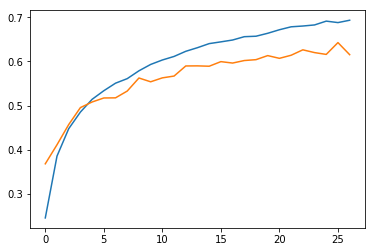

epoch 27 train 0.69258 test 0.6534


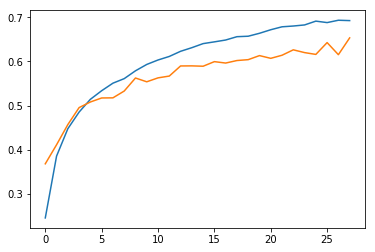

epoch 28 train 0.69964004 test 0.6341


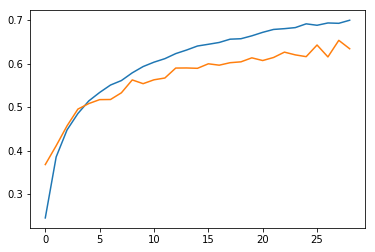

epoch 29 train 0.70693994 test 0.6391


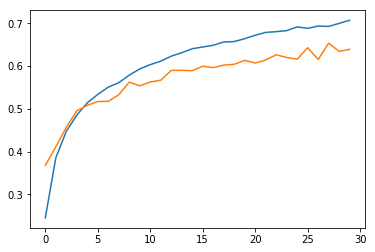

epoch 30 train 0.70802003 test 0.6568


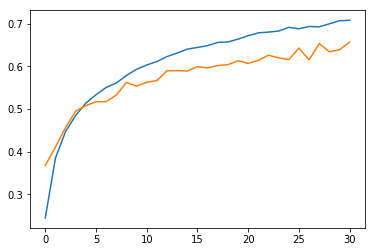

epoch 31 train 0.71278 test 0.6423


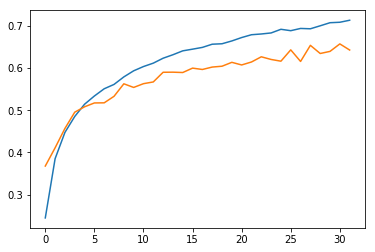

epoch 32 train 0.71258 test 0.6586


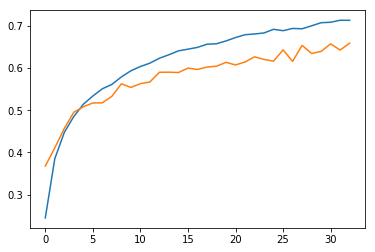

epoch 33 train 0.71753997 test 0.6652


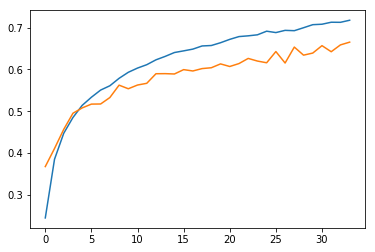

epoch 34 train 0.714 test 0.6491


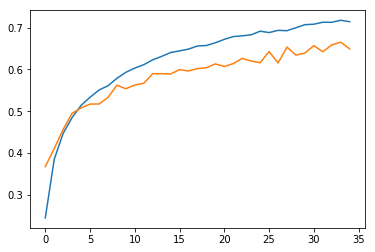

epoch 35 train 0.72073996 test 0.6397


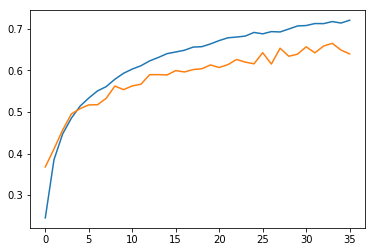

epoch 36 train 0.72298 test 0.6673


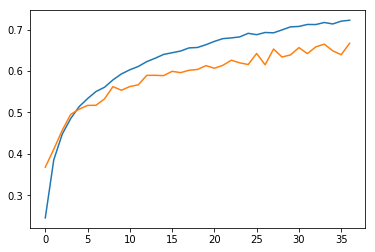

epoch 37 train 0.7300001 test 0.6662


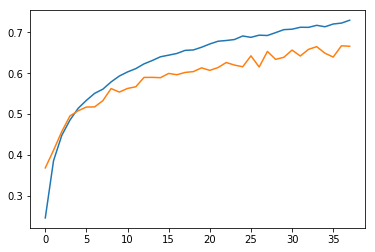

epoch 38 train 0.72606003 test 0.6447


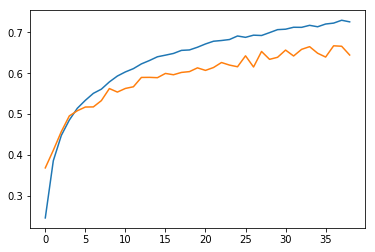

epoch 39 train 0.72954005 test 0.668


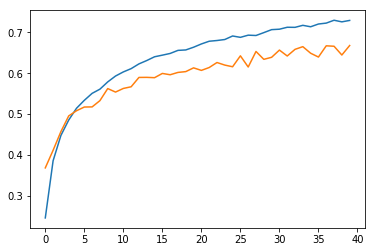

epoch 40 train 0.73058 test 0.6678


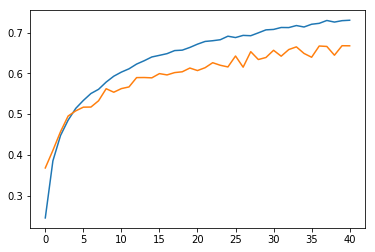

epoch 41 train 0.73714006 test 0.6545


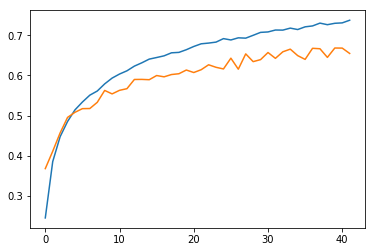

epoch 42 train 0.73451996 test 0.6426


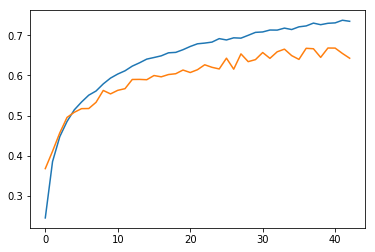

epoch 43 train 0.74072 test 0.6571


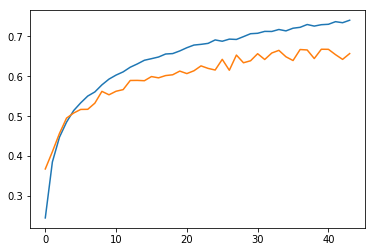

epoch 44 train 0.73754007 test 0.682


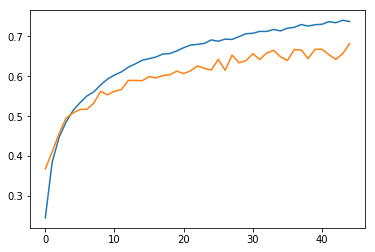

epoch 45 train 0.7441 test 0.683


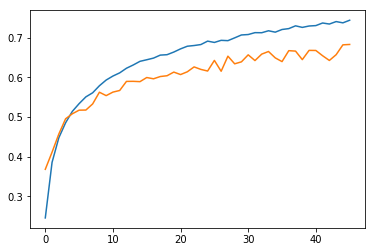

epoch 46 train 0.74509996 test 0.6824


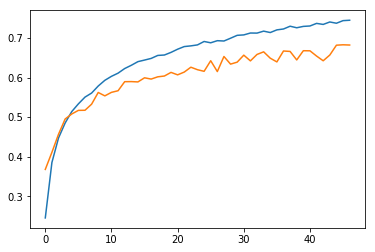

epoch 47 train 0.74100006 test 0.6842


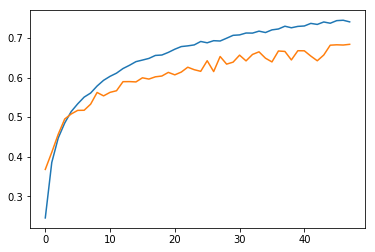

epoch 48 train 0.7453201 test 0.6889


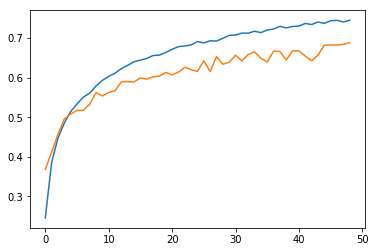

epoch 49 train 0.74657995 test 0.6854


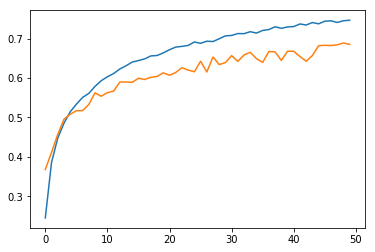

epoch 50 train 0.74618006 test 0.6828


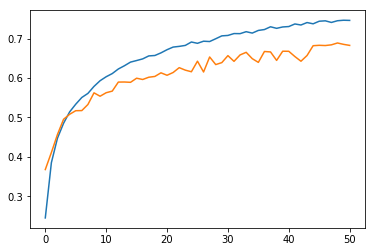

epoch 51 train 0.74364 test 0.6777


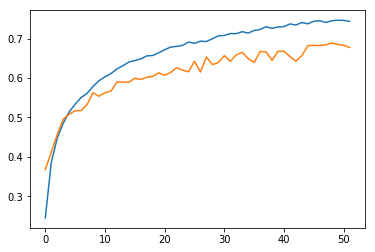

epoch 52 train 0.74604005 test 0.6801


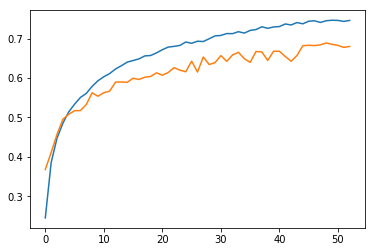

epoch 53 train 0.7504 test 0.6624


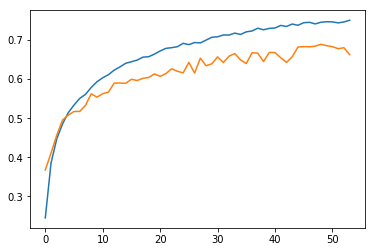

epoch 54 train 0.75414 test 0.6651


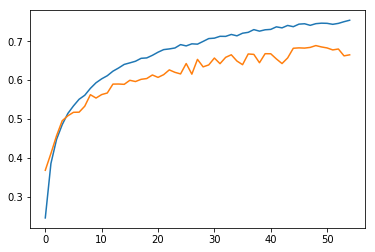

epoch 55 train 0.75344 test 0.6767


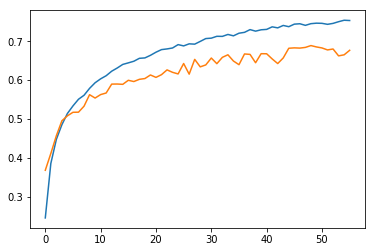

epoch 56 train 0.75498 test 0.6625


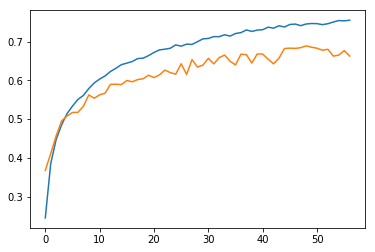

epoch 57 train 0.75368 test 0.6882


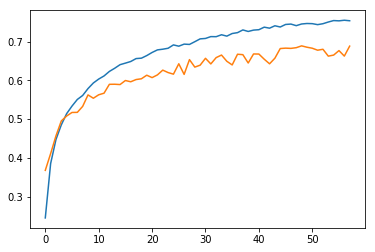

epoch 58 train 0.7605999 test 0.6876


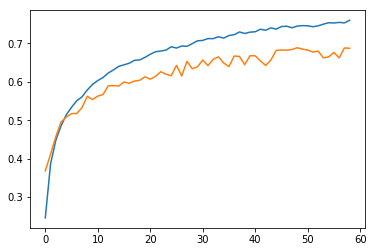

epoch 59 train 0.76058 test 0.6977


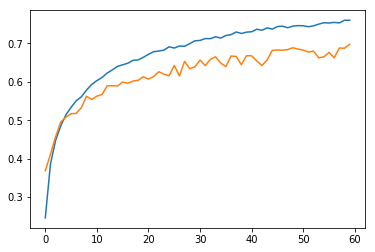

epoch 60 train 0.76002 test 0.6856


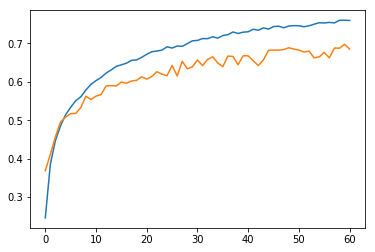

epoch 61 train 0.75932 test 0.6779


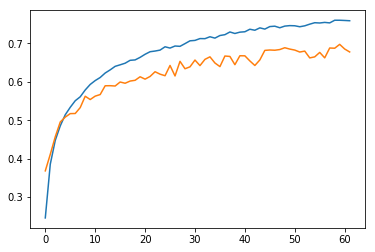

epoch 62 train 0.76194 test 0.7047


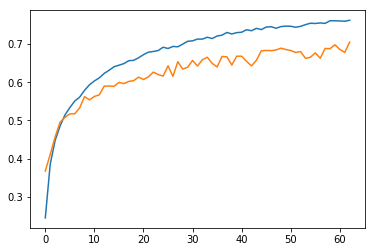

epoch 63 train 0.76676005 test 0.7097


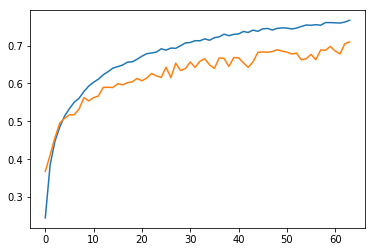

epoch 64 train 0.7638 test 0.7116


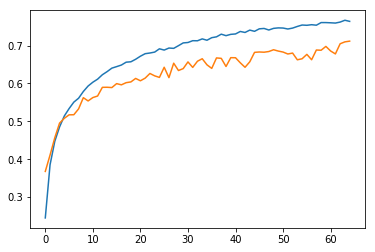

epoch 65 train 0.76668 test 0.7155


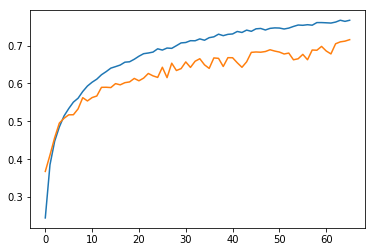

epoch 66 train 0.7686199 test 0.7101


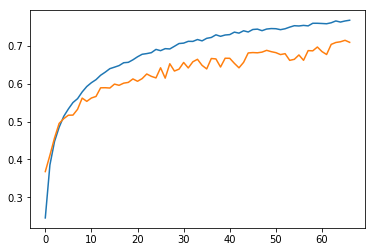

epoch 67 train 0.77114 test 0.69


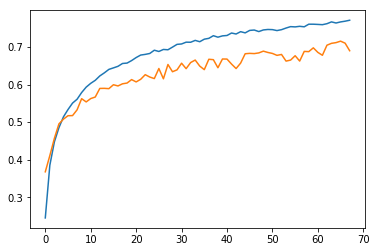

epoch 68 train 0.76488006 test 0.684


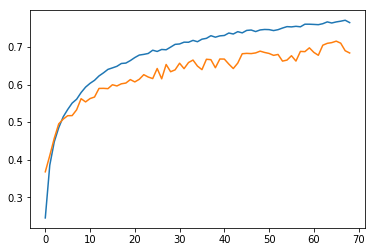

epoch 69 train 0.7712 test 0.712


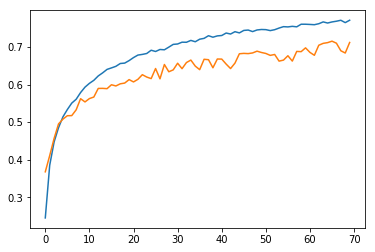

epoch 70 train 0.76952004 test 0.71


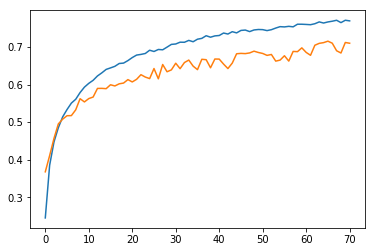

epoch 71 train 0.7722399 test 0.7128


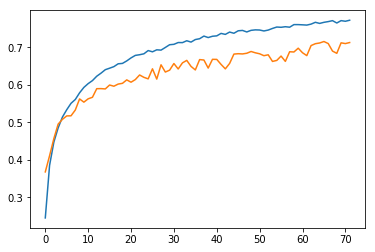

epoch 72 train 0.77307993 test 0.7139


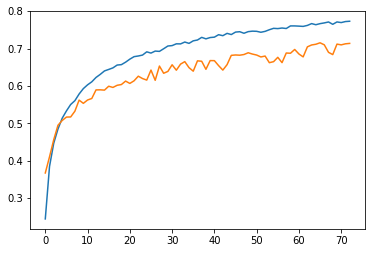

epoch 73 train 0.76934 test 0.7293


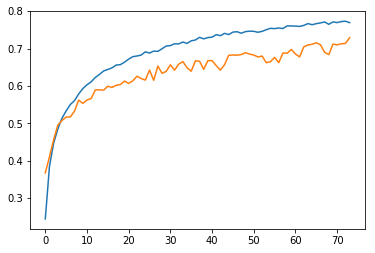

epoch 74 train 0.76835996 test 0.7214


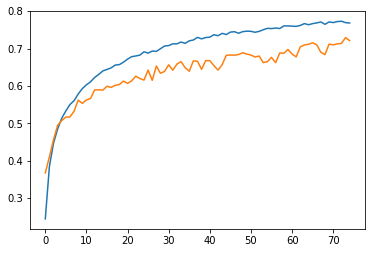

epoch 75 train 0.7710001 test 0.721


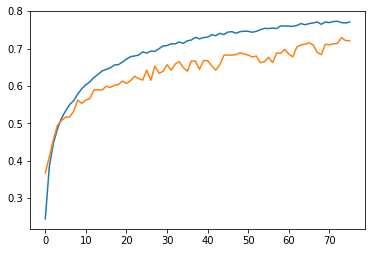

epoch 76 train 0.77261996 test 0.7112


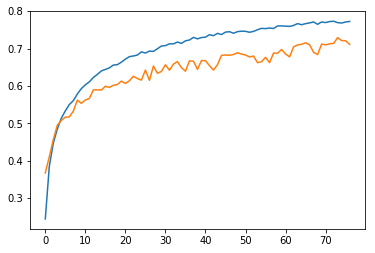

epoch 77 train 0.77504 test 0.7182


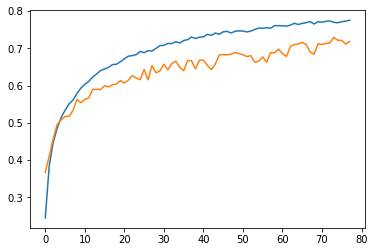

epoch 78 train 0.77690005 test 0.7228


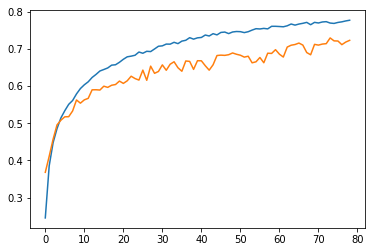

epoch 79 train 0.7755799 test 0.7242


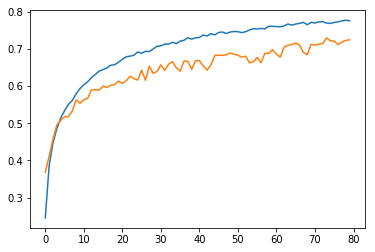

epoch 80 train 0.7785599 test 0.7086


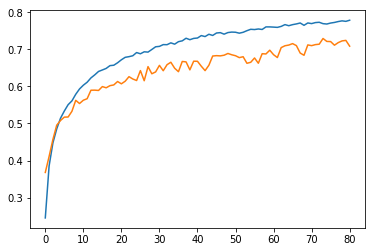

epoch 81 train 0.78116006 test 0.7213


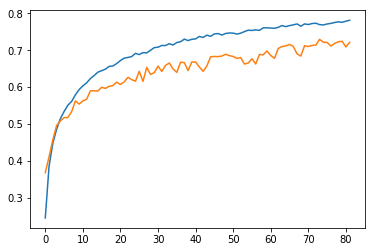

epoch 82 train 0.77839994 test 0.7159


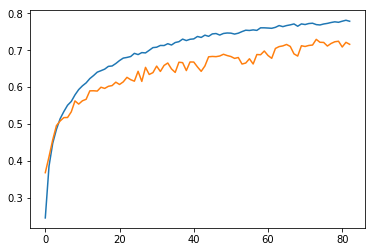

epoch 83 train 0.77592 test 0.7222


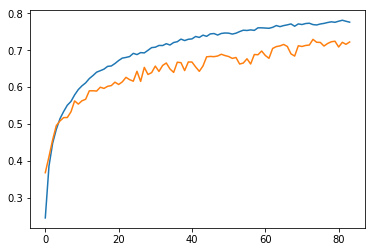

epoch 84 train 0.77516 test 0.7145


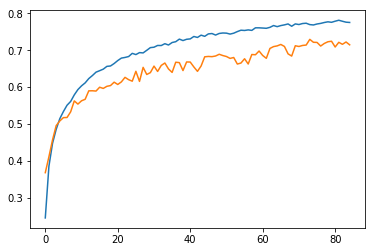

epoch 85 train 0.78270006 test 0.7123


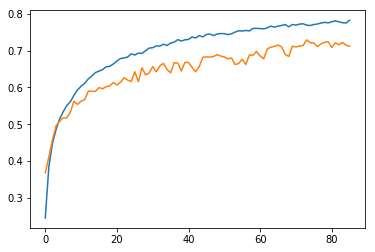

epoch 86 train 0.77926004 test 0.7107


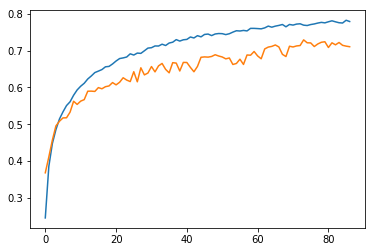

epoch 87 train 0.77706003 test 0.7264


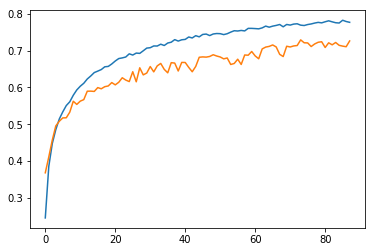

epoch 88 train 0.77918005 test 0.7057


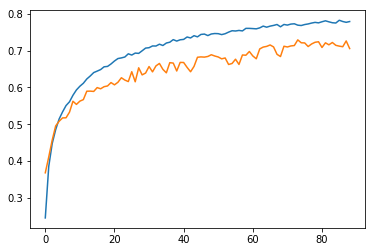

epoch 89 train 0.78178 test 0.7159


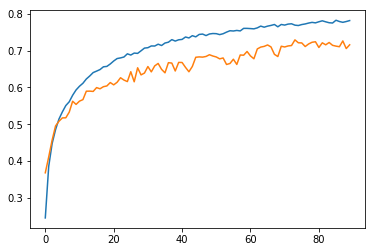

epoch 90 train 0.77870005 test 0.7114


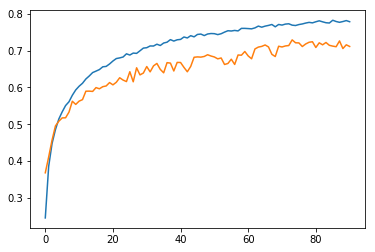

epoch 91 train 0.78073996 test 0.7211


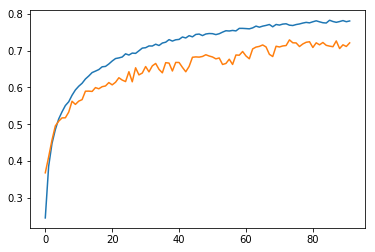

epoch 92 train 0.78300005 test 0.7117


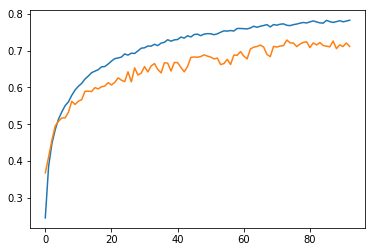

epoch 93 train 0.78706 test 0.7065


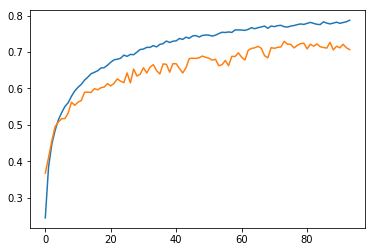

epoch 94 train 0.7825999 test 0.7069


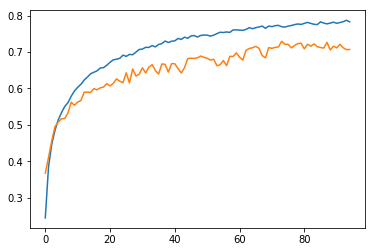

epoch 95 train 0.78790003 test 0.7164


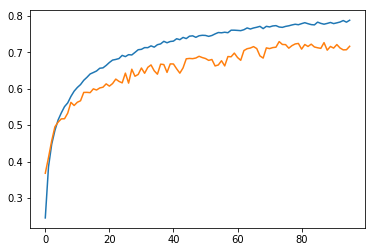

epoch 96 train 0.7888 test 0.7299


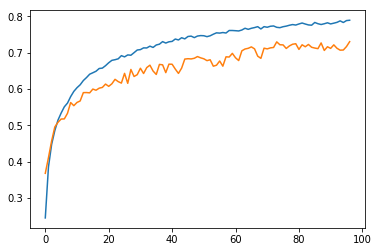

epoch 97 train 0.78832 test 0.7131


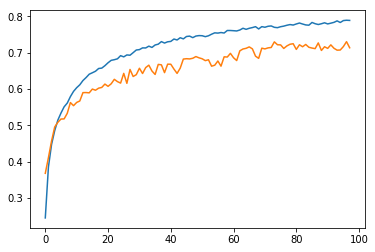

epoch 98 train 0.78594 test 0.7051


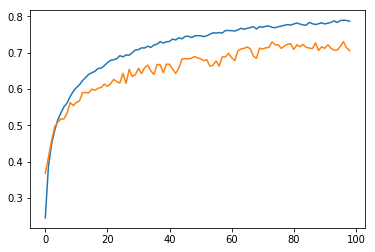

epoch 99 train 0.79326004 test 0.7238


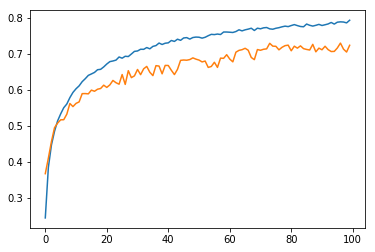

In [192]:
ac_train = []
ac_test = []

batch_size = 1000

for i in range(100):
    ac_train.append(train())
    ac_test.append(test())
    
    print("epoch " + str(i) + " train " + str(ac_train[i]) + " test " + str(ac_test[i]))
    
    plt.plot(ac_train)
    plt.plot(ac_test)
    plt.show()
    

## Close the session

In [0]:
session.close()

## References

[1] [Arm Community](https://community.arm.com)